In [ ]:
# Importing modules
import pandas as pd
import os

os.chdir('..')

# Read data into papers
papers = pd.read_csv('/content/All Airlines.csv')

# Print head
papers.head()

,Unnamed: 0,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,0,United Airlines,1.0,Zachary Christensen,21st May 2022,✅ Trip Verified | Worst experience I have ever...,NaN,Couple Leisure,Economy Class,"Salt Lake City to Portland, Maine",22-May,1.0,1.0,NaN,NaN,1.0,1.0,no
1,1,United Airlines,2.0,Barbara Contente,21st May 2022,✅ Trip Verified | Very displeased with the fac...,NaN,Solo Leisure,Economy Class,Los Angeles to Lisbon via Washington,22-May,1.0,3.0,2.0,3.0,3.0,2.0,no
2,2,United Airlines,1.0,Gabe Hunters,21st May 2022,Not Verified | Absolutely terrible experience....,NaN,Family Leisure,Economy Class,"Kansas City, Missouri to Newark, New York",22-May,1.0,1.0,1.0,1.0,1.0,1.0,no
3,3,United Airlines,1.0,N Geale,21st May 2022,✅ Trip Verified | We were scheduled to leave P...,NaN,Couple Leisure,Economy Class,Pittsburgh to Newark,22-May,3.0,3.0,NaN,NaN,1.0,1.0,no
4,4,United Airlines,8.0,R Gonzaga,19th May 2022,✅ Trip Verified | First leg of trip to KUL. Dr...,Boeing 737-900Max,Solo Leisure,Premium Economy,Baltimore to Chicago O'Hare,22-May,2.0,4.0,3.0,NaN,2.0,4.0,yes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
papers = papers.drop(columns=['Unnamed: 0', 'overall', 'author','review_date', 'aircraft', 'traveller_type','cabin','route','date_flown','seat_comfort','cabin_service','food_bev',
                              'entertainment','ground_service','value_for_money','recommended'])

# Print out the first rows of papers
papers.head()



,airline,customer_review
0,United Airlines,✅ Trip Verified | Worst experience I have ever...
1,United Airlines,✅ Trip Verified | Very displeased with the fac...
2,United Airlines,Not Verified | Absolutely terrible experience....
3,United Airlines,✅ Trip Verified | We were scheduled to leave P...
4,United Airlines,✅ Trip Verified | First leg of trip to KUL. Dr...


In [ ]:
# Load the regular expression library
import re

papers['customer_review']=papers['customer_review'].apply(str)
# Remove punctuation
papers['customer_review'] = papers['customer_review'].map(lambda x: re.sub('[,\|.!?]', '', x))

# Convert the titles to lowercase
papers['customer_review'] = papers['customer_review'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['customer_review'].head()

0    ✅ trip verified  worst experience i have ever ...
1    ✅ trip verified  very displeased with the fact...
2    not verified  absolutely terrible experience b...
3    ✅ trip verified  we were scheduled to leave pi...
4    ✅ trip verified  first leg of trip to kul drea...
Name: customer_review, dtype: object

In [ ]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.customer_review.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['trip', 'verified', 'worst', 'experience', 'have', 'ever', 'had', 'flying', 'have', 'never', 'flown', 'united', 'and', 'do', 'not', 'plan', 'to', 'ever', 'again', 'first', 'flight', 'was', 'cancelled', 'on', 'the', 'th', 'of', 'may', 'and', 'then']


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


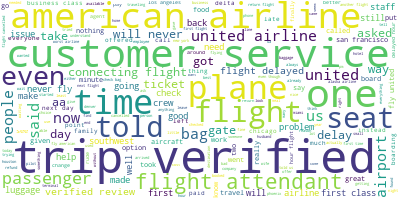

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['customer_review'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['trip', 'verify', 'bad', 'experience', 'ever', 'fly', 'never', 'fly', 'ever', 'first', 'flight', 'cancel', 'give', 'invalid', 'meal', 'hotel', 'voucher', 'customer', 'desk', 'find', 'take', 'shuttle', 'hotel', 'find', 'place', 'stay', 'flight', 'get', 'even', 'original']


In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 3), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1)]


In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.146*"seat" + 0.029*"pay" + 0.024*"sit" + 0.021*"plane" + 0.018*"extra" + '
  '0.017*"row" + 0.014*"together" + 0.014*"get" + 0.013*"board" + '
  '0.013*"first"'),
 (1,
  '0.140*"bag" + 0.125*"check" + 0.055*"luggage" + 0.039*"baggage" + '
  '0.029*"carry" + 0.013*"overhead" + 0.013*"fit" + 0.011*"space" + '
  '0.010*"deliver" + 0.010*"item"'),
 (2,
  '0.045*"flight" + 0.036*"fly" + 0.029*"airline" + 0.025*"time" + '
  '0.014*"make" + 0.011*"american" + 0.010*"travel" + 0.010*"year" + '
  '0.009*"trip" + 0.009*"last"'),
 (3,
  '0.035*"say" + 0.034*"ask" + 0.028*"go" + 0.025*"tell" + 0.020*"line" + '
  '0.017*"help" + 0.017*"get" + 0.016*"staff" + 0.016*"could" + '
  '0.013*"people"'),
 (4,
  '0.039*"passenger" + 0.015*"safety" + 0.014*"attendant" + 0.010*"crew" + '
  '0.010*"game" + 0.009*"music" + 0.009*"play" + 0.009*"collect" + 0.009*"bed" '
  '+ 0.008*"adequate"'),
 (5,
  '0.086*"flight" + 0.044*"hour" + 0.034*"delay" + 0.028*"plane" + '
  '0.025*"time" + 0.024*"get" + 0.0

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.42120412148676556


In [ ]:
!pip install pyLDAvis==2.1.2

In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./content/ldavis-_'+str(num_topics))

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './content/ldavis-'+ str(num_topics) +'.html')

LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.177692 -0.018536       1        1  22.408174
2      0.110937  0.127641       2        1  18.525649
6      0.156497 -0.044361       3        1  14.839706
9     -0.004301  0.080505       4        1  12.331157
3      0.019691 -0.129243       5        1   8.534710
0      0.004379 -0.134632       6        1   6.064601
7     -0.001381  0.190463       7        1   5.909486
8      0.128925  0.039048       8        1   5.727555
1     -0.213410 -0.285255       9        1   3.628944
4     -0.379029  0.174369      10        1   2.030018, topic_info=          Term         Freq        Total Category  logprob  loglift
67        seat  8789.000000  8789.000000  Default  30.0000  30.0000
5        check  5244.000000  5244.000000  Default  29.0000  29.0000
2          bag  3538.000000  3538.000000  Default  28.0000  28.0000
7     customer  5530.000000  5530.000000  Default  27.0000  27.0000
33     service  6634.000000  6634.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
559      thank    88.764500   398.478531  Topic10  -5.0710   2.3955
841      great    95.505305   996.800178  Topic10  -4.9978   1.5518
2163  domestic    83.528965   512.166020  Topic10  -5.1318   2.0837
154      pilot    85.800926   783.011834  Topic10  -5.1050   1.6860
536    concern    71.449463   263.919643  Topic10  -5.2880   2.5905

[662 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1081      8  0.991181     ability
78        1  0.124171  absolutely
78        2  0.222075  absolutely
78        7  0.644733  absolutely
78        8  0.009552  absolutely
...     ...       ...         ...
180       9  0.019889       would
238       2  0.882245        year
238       3  0.056181        year
238       7  0.061729        year
848       5  0.994842        yell

[1188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 10, 4, 1, 8, 9, 2, 5])